## Index
1. [Model1](#model1) - Convolution layers over word2vec 
2. [Model2](#model2) - RNN over word2vec
3. [Model3](#model3) - doc2vec using TF-IDF with word2vec
0. [Prediction](#predict) 

In [42]:
import pandas as pd       
import numpy as np
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import Word2Vec
import re
import lasagne
from lasagne import layers
from lasagne.layers import InputLayer,Conv1DLayer,rrelu,prelu,batch_norm,\
DenseLayer,ExpressionLayer,MaxPool1DLayer,GRULayer,ConcatLayer,ElemwiseMergeLayer,Gate
from lasagne.updates import nesterov_momentum,adam
from lasagne.nonlinearities import very_leaky_rectify,tanh
from theano import tensor as tt
import theano
import matplotlib.pyplot as plt
from GBM2 import GBM_KClass
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.cross_validation import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier,ExtraTreeClassifier,ExtraTreeRegressor
from sklearn.metrics import roc_auc_score 
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.stochastic import sample
%matplotlib inline

In [2]:
train = pd.read_csv("/home/will/Desktop/data/Movie sentiment/labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)

In [3]:
test = pd.read_csv("/home/will/Desktop/data/Movie sentiment/testData.tsv", header=0, \
                    delimiter="\t", quoting=3)

unlabel = pd.read_csv("/home/will/Desktop/data/Movie sentiment/unlabeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)

In [4]:
model = Word2Vec.load_word2vec_format('/home/will/Desktop/data/Word2Vec/GoogleNews-vectors-negative300.bin', binary=True)  

In [5]:
def review_to_wordlist(review,stop):

    review_text = BeautifulSoup(review).get_text()
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    words = review_text.lower().split()
    
    words = [w for w in words if not w in stops]

    return words

In [6]:
stops = set(stopwords.words("english"))

In [7]:
X_str = []
for i in range(train.shape[0]):
    X_str.append(review_to_wordlist(train.review.iloc[i],stops))

/home/will/anaconda2/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file /home/will/anaconda2/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [8]:
X_str_test = []
for i in range(test.shape[0]):
    X_str_test.append(review_to_wordlist(test.review.iloc[i],stops))

In [9]:
y = train.sentiment.values

In [10]:
n = y.shape[0]
y_np = np.zeros((n,2))
y_np[range(n),y]=1
y_np=y_np.astype('int64')

In [11]:
X_train = X_str[:20000]
y_train = y_np[:20000]
X_val = X_str[20000:]
y_val = y_np[20000:]

unlabel_str = []
for i in range(unlabel.shape[0]):
    unlabel_str.append(review_to_wordlist(unlabel.review.iloc[i],stops))

Build Batch iterator

In [12]:
def batch_iterator(X, y, WordVec, batchsize, shuffle=False, sublen=1.0):
    # inputs is a list of list, targets in np.ndarray
    # random "crop" of review, with length = int(min(sentence lenth in batch) * sublen)
    
    n = len(X)
    if shuffle:
        indices = np.random.permutation(n)
    else:
        indices = range(n)

    for start_idx in range(0, n - batchsize + 1, batchsize):
        length_ = np.zeros(batchsize,dtype='int64')
        batch_ = indices[start_idx:start_idx + batchsize]
        for i,j in enumerate(batch_): # find the min_len of batch
            length_[i] = len(X[j])
        min_len = int(length_.min() * sublen)
        sample_len = length_ - min_len + 1

        for i in range(batchsize): # sample start position
            sample_len[i] = np.random.randint(sample_len[i])
        
        X_batch = np.zeros((batchsize,300,min_len)) # 300 is the word vector's length
        
        for i in range(batchsize):
            for j in range(min_len):
                if X[batch_[i]][sample_len[i]+j] in WordVec:
                    X_batch[i,:,j] = WordVec[X[batch_[i]][sample_len[i]+j]]

        if y==None: # test 
            yield X_batch.astype('float32'), batch_
        else:
            yield X_batch.astype('float32'), y[batch_].astype('float32')

In [49]:
def batch_iterator_rnn(X, y, WordVec, batchsize, shuffle=False, sublen=1.0):
    # inputs is a list of list, targets in np.ndarray
    # random "crop" of review, with length = int(min(sentence lenth in batch) * sublen)
    
    n = len(X)
    if shuffle:
        indices = np.random.permutation(n)
    else:
        indices = range(n)

    for start_idx in range(0, n - batchsize + 1, batchsize):
        length_ = np.zeros(batchsize,dtype='int64')
        batch_ = indices[start_idx:start_idx + batchsize]
        for i,j in enumerate(batch_): # find the min_len of batch
            length_[i] = len(X[j])
        min_len = int(length_.min() * sublen)
        sample_len = length_ - min_len + 1

        for i in range(batchsize): # sample start position
            sample_len[i] = np.random.randint(sample_len[i])
        
        X_batch = np.zeros((batchsize,min_len,300)) # 300 is the word vector's length
        
        for i in range(batchsize):
            for j in range(min_len):
                if X[batch_[i]][sample_len[i]+j] in WordVec:
                    X_batch[i,j,:] = WordVec[X[batch_[i]][sample_len[i]+j]]
        
        #if np.random.rand()<flip:
        #    X_batch = X_batch[:,::-1,:]
            
        if y==None: # test 
            yield X_batch.astype('float32'), batch_
        else:
            yield X_batch.astype('float32'), y[batch_].astype('float32')

In [248]:
def create_fun(batch_size, n_layer,n_filter,filter_size,connect_layer,ExpressFun,n_dense,\
               update_dic):
    
    update_method = update_dic['mtd']
    update_para = update_dic['para']
    
    X_tt = tt.tensor3()
    y_tt = tt.matrix()
    
    net = InputLayer(shape=(batch_size,300,None),input_var=X_tt)
    
    for _ in range(n_layer):
        net = connect_layer(Conv1DLayer(net,n_filter,filter_size,pad='same'))

    net = ExpressionLayer(net, lambda X: ExpressFun(X,2),output_shape=(batch_size,n_filter))
    net = connect_layer(DenseLayer(net, num_units=n_dense))
    net = DenseLayer(net, num_units=2,nonlinearity=tt.nnet.softmax)
    
    Y_hat = layers.get_output(net)
    Y_hat_test = layers.get_output(net,deterministic=True)
    
    cost = -tt.sum(tt.log(Y_hat)*y_tt)
    params = lasagne.layers.get_all_params(net, trainable=True)
    updates = update_method(cost, params, **update_para)
    train_fn = theano.function([X_tt, y_tt], updates=updates)
    predict  = theano.function([X_tt],Y_hat_test)
    
    return train_fn, predict

In [249]:
def hyperPara(params):
    
    batch_size=int(params[0])
    n_layer=int(params[1])
    n_filter=int(params[2])
    filter_size=int(params[3])
    connect_layer=params[4]
    ExpressFun=params[5]
    n_dense=int(params[6])
    update_dic=params[7]
    
    n_batch = 30
    best_score = .0
    counter = 0
    yhat = np.zeros((len(X_val),2))
    
    train_fn, predict = create_fun(batch_size, n_layer,n_filter,filter_size,connect_layer,ExpressFun,n_dense,\
                                   update_dic)
    
    for i in range(n_batch):

        for x_bat,y_bat in batch_iterator(X_train, y_train, model, batch_size, shuffle=True, sublen=1.0):
            train_fn(x_bat,y_bat)

        for x_bat,batch in batch_iterator(X_val, None, model, batch_size, shuffle=False, sublen=1.0):
            yhat[batch]=predict(x_bat)

        score_ = roc_auc_score(np.argmax(y_val,1),yhat[:,1])
        
        if score_ > best_score:
            best_score = score_
            counter = 0
        else:
            counter+=1
            if counter > 2 and i > 10: # early stop
                break 
        
        
    print 'batch_size:{}, n_layer:{},n_filter:{},filter_size:{},connect_layer:{},ExpressFun:{},n_dense:{},\
              update_method:{}, update_para:{}, accuracy:{}'\
    .format(batch_size, n_layer,n_filter,filter_size,connect_layer,ExpressFun,n_dense,\
              update_dic['mtd'], update_dic['para'],best_score)    
    
    return -best_score 

In [250]:
space =[hp.quniform('batch_size',10,40,5),\
        hp.quniform('n_layer',1,5,1),\
        hp.quniform('n_filter',100,500,100),\
        hp.quniform('filter_size',3,10,2) - 1,\
        hp.choice('connect_layer',[rrelu,prelu,batch_norm]),\
        hp.choice('ExpressFun',[tt.max, tt.mean]),\
        hp.quniform('n_dense',50,300,50),\
        hp.choice('update_method',\
                  [{'mtd':nesterov_momentum, 'para':{'learning_rate':2e-5*2**(-hp.quniform('nest_r',1,5,1)),\
                                                     'momentum':hp.uniform('nest_mom',0.6,0.99)}},\
                   {'mtd':adam, 'para':{'learning_rate':2e-5*2**(-hp.quniform('ada_r',1,5,1))}}
                  ])
        ]

In [251]:
trials = Trials()

In [252]:
best = fmin(hyperPara, space, algo=tpe.suggest, trials=trials, max_evals=100)

/home/will/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


batch_size:30, n_layer:4,n_filter:400,filter_size:7,connect_layer:<function prelu at 0x7f0974b87e60>,ExpressFun:<function max at 0x7f098522b758>,n_dense:150,              update_method:<function nesterov_momentum at 0x7f0974b8daa0>, update_para:{'learning_rate': 1.25e-06, 'momentum': 0.767103661212862}, accuracy:0.723261365906
batch_size:20, n_layer:3,n_filter:300,filter_size:3,connect_layer:<function batch_norm at 0x7f0974b70050>,ExpressFun:<function mean at 0x7f09852498c0>,n_dense:100,              update_method:<function nesterov_momentum at 0x7f0974b8daa0>, update_para:{'learning_rate': 1.25e-06, 'momentum': 0.986151994639652}, accuracy:0.848769829687
batch_size:35, n_layer:5,n_filter:200,filter_size:3,connect_layer:<function rrelu at 0x7f0974b8d050>,ExpressFun:<function max at 0x7f098522b758>,n_dense:250,              update_method:<function adam at 0x7f0974b8dc80>, update_para:{'learning_rate': 2.5e-06}, accuracy:0.798788680052
batch_size:10, n_layer:2,n_filter:200,filter_size:3,

In [254]:
best

{'ExpressFun': 0,
 'ada_r': 1.0,
 'batch_size': 10.0,
 'connect_layer': 0,
 'filter_size': 6.0,
 'n_dense': 50.0,
 'n_filter': 200.0,
 'n_layer': 2.0,
 'update_method': 1}

<a id='model1'></a>
1. Model1 - Conv layer over word2vec from google, with optimized hyperpara from hyperopt over whole dataset

In [27]:
X_tt = tt.tensor3()
y_tt = tt.matrix()
learning_rate_tt = tt.scalar()
m_tt = tt.scalar()

In [28]:
net = InputLayer(shape=(10,300,None),input_var=X_tt)
net = rrelu(Conv1DLayer(net,200,5,pad='same'))
net = rrelu(Conv1DLayer(net,200,5,pad='same'))
net = ExpressionLayer(net, lambda X: tt.max(X,2),output_shape=(10,200))
#net = rrelu(ExpressionLayer(net, lambda X: tt.mean(X,2),output_shape=(10,200)))
#net = rrelu(DenseLayer(net, num_units=100))
net = rrelu(DenseLayer(net, num_units=50))
net = DenseLayer(net, num_units=2,nonlinearity=tt.nnet.softmax)

In [29]:
Y_hat = layers.get_output(net)

In [30]:
cost = -tt.sum(tt.log(Y_hat)*y_tt)

In [31]:
err = tt.sum(tt.eq(tt.argmax(Y_hat,1),tt.argmax(y_tt,1)))

In [32]:
params = lasagne.layers.get_all_params(net, trainable=True)
updates = adam(cost, params, learning_rate=learning_rate_tt)

In [33]:
train_fn = theano.function([X_tt, y_tt,learning_rate_tt], updates=updates)

In [34]:
predict  = theano.function([X_tt],Y_hat)

In [35]:
loss = theano.function([X_tt, y_tt], err)

Whole dataset refit - final model

In [36]:
n_batch = 20

for i in range(n_batch):
    
    for x_bat,y_bat in batch_iterator(X_str, y_np, model, 10, shuffle=True, sublen=1.0):
        train_fn(x_bat,y_bat,1e-5)

/home/will/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


n_batch = 10
best_err = .0
yhat = np.zeros((len(X_val),2))

for i in range(n_batch):
    
    for x_bat,y_bat in batch_iterator(X_train, y_train, model, 10, shuffle=True, sublen=1.0):
        train_fn(x_bat,y_bat,1e-5)
    
    for x_bat,batch in batch_iterator(X_val, None, model, 10, shuffle=False, sublen=1.0):
        yhat[batch]=predict(x_bat)

    err = roc_auc_score(np.argmax(y_val,1),yhat[:,1])
    if err > best_err:
        best_err = err
        best_para = layers.get_all_param_values(net)
    
    print 'epoch:{}, accuracy:{}'.format(i,err)

layers.set_all_param_values(net,best_para)

In [88]:
def create_fun_RNN(n_layer,n_batch,n_unit,cell1,cell2,cell3,nonlin1,connect1,fun1,fun2,n_dense,\
               update_dic):
    
    update_method = update_dic['mtd']
    update_para = update_dic['para']
    
    X_tt = tt.tensor3()
    y_tt = tt.matrix()
    
    net = InputLayer(shape=(n_batch,None,300),input_var=X_tt)

    for _ in range(n_layer):
        net_fw = GRULayer(net,n_unit,grad_clipping=100.,\
                            resetgate=Gate(W_cell=cell1),\
                            updategate=Gate(W_cell=cell2),\
                            hidden_update=Gate(W_cell=cell3, nonlinearity=nonlin1))
        net_bw = GRULayer(net,n_unit,grad_clipping=100.,backwards=True,\
                            resetgate=Gate(W_cell=cell1),\
                            updategate=Gate(W_cell=cell2),\
                            hidden_update=Gate(W_cell=cell3, nonlinearity=nonlin1))
        
        if connect1 == batch_norm:
            net = connect1(ElemwiseMergeLayer([net_fw,net_bw],merge_function=fun1),axes=(0,1))
        elif connect1 == "identity":
            net = ElemwiseMergeLayer([net_fw,net_bw],merge_function=fun1)
        else:
            net = connect1(ElemwiseMergeLayer([net_fw,net_bw],merge_function=fun1),shared_axes=(0,1))
    
            
    if connect1 == batch_norm:
        net = connect1(ExpressionLayer(net, lambda X: fun2(X,1),output_shape=(n_batch,n_unit)),axes=(0,1))
    elif connect1 == "identity":
        net = ExpressionLayer(net, lambda X: fun2(X,1),output_shape=(n_batch,n_unit))
    else:
        net = connect1(ExpressionLayer(net, lambda X: fun2(X,1),output_shape=(n_batch,n_unit)),shared_axes=(0,1))
        
        
    if connect1 == "identity":
        net = DenseLayer(net, num_units=n_dense)
    else:
        net = connect1(DenseLayer(net, num_units=n_dense))
        
    net = DenseLayer(net, num_units=2,nonlinearity=tt.nnet.softmax)
    
    Y_hat = layers.get_output(net)
    Y_hat_test = layers.get_output(net,deterministic=True)
    
    cost = -tt.sum(tt.log(Y_hat)*y_tt)
    params = lasagne.layers.get_all_params(net, trainable=True)
    updates = update_method(cost, params, **update_para)
    train_fn = theano.function([X_tt, y_tt], updates=updates)
    predict  = theano.function([X_tt],Y_hat_test)
    
    return train_fn, predict 

In [89]:
def hyperPara_RNN(params):
    
    n_layer=int(params[0])
    batch_size=int(params[1])
    n_unit=int(params[2])
    cell1=params[3]
    cell2=params[4]
    cell3=params[5]
    nonlin1=params[6]
    connect1=params[7]
    fun1=params[8]
    fun2=params[9]
    n_dense=int(params[10])
    update_dic=params[11]


    n_batch = 30
    best_score = .0
    counter = 0
    yhat = np.zeros((len(X_val),2))
    
    train_fn, predict = create_fun_RNN(n_layer,batch_size,n_unit,cell1,cell2,cell3,nonlin1,connect1,\
                                       fun1,fun2,n_dense,update_dic)
    
    for i in range(n_batch):

        for x_bat,y_bat in batch_iterator_rnn(X_train, y_train, model, batch_size, shuffle=True, sublen=1.0):
            train_fn(x_bat,y_bat)

        for x_bat,batch in batch_iterator_rnn(X_val, None, model, batch_size, shuffle=False, sublen=1.0):
            yhat[batch]=predict(x_bat)

        score_ = roc_auc_score(np.argmax(y_val,1),yhat[:,1])
        
        if score_ > best_score:
            best_score = score_
            counter = 0
        else:
            counter+=1
            if counter > 2 and i > 10: # early stop
                break 
        
        
    print 'batch_size:{}, n_layer:{},n_unit:{},cell1:{},cell2:{},cell3:{},\
           nonlin1:{},connect1:{},n_dense:{},fun1:{},fun2:{},\
              update_method:{}, update_para:{},  ### Accuracy:{} ###'\
    .format(batch_size, n_layer,n_unit,cell1,cell2,cell3,nonlin1,connect1,n_dense,fun1,fun2,\
              update_dic['mtd'], update_dic['para'],best_score)    
    
    return -best_score   

In [90]:
space =[hp.quniform('n_layer',1,2,1),\
        hp.quniform('batch_size',10,40,5),\
        hp.quniform('n_unit',100,500,100),\
        hp.choice('cell1',[True, False]),\
        hp.choice('cell2',[True, False]),\
        hp.choice('cell3',[True, False]),\
        hp.choice('nonlin1',[very_leaky_rectify,tanh]),\
        hp.choice('connect1',[rrelu,prelu,batch_norm,"identity"]),\
        hp.choice('fun1',[tt.add, tt.maximum]),\
        hp.choice('fun2',[tt.sum, tt.max]),\
        hp.quniform('n_dense',50,300,50),\
        hp.choice('update_method',\
                  [{'mtd':nesterov_momentum, 'para':{'learning_rate':4e-5*2**(-hp.quniform('nest_r',1,5,1)),\
                                                     'momentum':hp.uniform('nest_mom',0.7,0.99)}},\
                   {'mtd':adam, 'para':{'learning_rate':4e-5*2**(-hp.quniform('ada_r',1,5,1))}}
                  ])
        ]  

In [91]:
trials = Trials()

In [92]:
best = fmin(hyperPara_RNN, space, algo=tpe.suggest, trials=trials, max_evals=50)

/home/will/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:32: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


batch_size:20, n_layer:2,n_unit:300,cell1:False,cell2:True,cell3:False,           nonlin1:<function tanh at 0x7f8c9e28a398>,connect1:<function rrelu at 0x7f8c9bd11668>,n_dense:150,fun1:Elemwise{maximum,no_inplace},fun2:<function sum at 0x7f8cb7718758>,              update_method:<function nesterov_momentum at 0x7f8c9bd15140>, update_para:{'learning_rate': 1e-05, 'momentum': 0.7657869215336188},  ### Accuracy:0.819153634632 ###
batch_size:35, n_layer:1,n_unit:300,cell1:True,cell2:False,cell3:False,           nonlin1:<lasagne.nonlinearities.LeakyRectify object at 0x7f8c9e285d90>,connect1:<function rrelu at 0x7f8c9bd11668>,n_dense:100,fun1:Elemwise{add,no_inplace},fun2:<function max at 0x7f8cb76fb6e0>,              update_method:<function nesterov_momentum at 0x7f8c9bd15140>, update_para:{'learning_rate': 2.5e-06, 'momentum': 0.8659709256231347},  ### Accuracy:0.75831736333 ###
batch_size:20, n_layer:2,n_unit:100,cell1:False,cell2:True,cell3:False,           nonlin1:<function tanh at 0x7f

KeyboardInterrupt: 

<a id='model2'></a>
Model2 - RNN over word2vec from google

In [328]:
X_tt = tt.tensor3()
y_tt = tt.matrix()
learning_rate_tt = tt.scalar()
m_tt = tt.scalar()

In [329]:
l_in = InputLayer(shape=(10,None,300),input_var=X_tt)
# first layer 
net_fw = GRULayer(l_in,150,grad_clipping=100.,\
        hidden_update=lasagne.layers.Gate(W_cell=None, nonlinearity=lasagne.nonlinearities.very_leaky_rectify))
net_bw = GRULayer(l_in,150,grad_clipping=100.,backwards=True,\
        hidden_update=lasagne.layers.Gate(W_cell=None, nonlinearity=lasagne.nonlinearities.very_leaky_rectify))
#net = ElemwiseMergeLayer([net_fw,net_bw],merge_function=tt.maximum)
net = rrelu(ElemwiseMergeLayer([net_fw,net_bw],merge_function=tt.add))
# second layer 
net_fw = GRULayer(net,150,grad_clipping=100.,\
        hidden_update=lasagne.layers.Gate(W_cell=None, nonlinearity=lasagne.nonlinearities.very_leaky_rectify))
net_bw = GRULayer(net,150,grad_clipping=100.,backwards=True,\
        hidden_update=lasagne.layers.Gate(W_cell=None, nonlinearity=lasagne.nonlinearities.very_leaky_rectify))
#net = ElemwiseMergeLayer([net_fw,net_bw],merge_function=tt.maximum)
net = rrelu(ElemwiseMergeLayer([net_fw,net_bw],merge_function=tt.add))
# third layer 
#net_fw = GRULayer(net,150,grad_clipping=100.,\
#        hidden_update=lasagne.layers.Gate(W_cell=None, nonlinearity=lasagne.nonlinearities.very_leaky_rectify))
#net_bw = GRULayer(net,150,grad_clipping=100.,backwards=True,\
#        hidden_update=lasagne.layers.Gate(W_cell=None, nonlinearity=lasagne.nonlinearities.very_leaky_rectify))
#net = ElemwiseMergeLayer([net_fw,net_bw],merge_function=tt.maximum)

net = rrelu(ExpressionLayer(net, lambda X: tt.sum(X,1),output_shape=(10,150)))
#net = ExpressionLayer(net, lambda X: tt.max(X,1),output_shape=(10,150))
net = rrelu(DenseLayer(net, num_units=50))
net = DenseLayer(net, num_units=2,nonlinearity=tt.nnet.softmax)

In [330]:
Y_hat = layers.get_output(net)

In [331]:
cost = -tt.sum(tt.log(Y_hat)*y_tt)

In [332]:
err = tt.sum(tt.eq(tt.argmax(Y_hat,1),tt.argmax(y_tt,1)))

In [333]:
params = lasagne.layers.get_all_params(net, trainable=True)
updates = lasagne.updates.nesterov_momentum(
            cost, params, learning_rate=learning_rate_tt, momentum=m_tt)

In [334]:
train_fn = theano.function([X_tt, y_tt,learning_rate_tt,m_tt], updates=updates)

In [335]:
predict  = theano.function([X_tt],Y_hat)

In [336]:
loss = theano.function([X_tt, y_tt], err)

In [52]:
n_batch = 4
yhat = np.zeros((len(X_val),2))

for i in range(n_batch):
    err = 0
    
    for x_bat,y_bat in batch_iterator_rnn(X_train, y_train, model, 10, shuffle=True, sublen=1.0):
        train_fn(x_bat,y_bat)
    
    for x_bat,batch in batch_iterator_rnn(X_val, None, model, 10, shuffle=False, sublen=1.0):
        yhat[batch]=predict(x_bat)
        
    score_ = roc_auc_score(np.argmax(y_val,1),yhat[:,1])
    
    print 'epoch:{}, accuracy:{}'.format(i,score_)

/home/will/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:32: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


epoch:0, accuracy:0.836342190764
epoch:1, accuracy:0.841098627412
epoch:2, accuracy:0.844984234822
epoch:3, accuracy:0.849357423395


<a id='model3'></a>
Model3 - doc2vec using TF-IDF with word2vec

In [13]:
train_frq = np.zeros((25000,300),dtype='float32')
test_frq = np.zeros((25000,300),dtype='float32')

In [14]:
for i in xrange(25000):
    temp = np.zeros(300,dtype='float32')
    for j in range(len(X_str[i])):
        if X_str[i][j] in model:
            temp += model[X_str[i][j]]
    train_frq[i] = temp/len(X_str[i])

In [15]:
for i in xrange(25000):
    temp = np.zeros(300,dtype='float32')
    for j in range(len(X_str_test[i])):
        if X_str_test[i][j] in model:
            temp += model[X_str_test[i][j]]
    test_frq[i] = temp/len(X_str_test[i])

In [329]:
def GBM_RandomSearch(X,y,Ntry,M,FixPara,RandomPara):
    # FixPara is a dict of fixed para
    # RandomPara is a list of tuple para for randomFun
    
    result = np.zeros((Ntry,5))
    
    for i in range(Ntry):
        RanPara={}
        result[i,0] = np.random.randint(*RandomPara[0])
        RanPara['subFold'] = result[i,0]
        
        BasePara={}
        result[i,1] = np.random.randint(*RandomPara[1])
        BasePara['max_depth'] = result[i,1]
        result[i,2] = np.random.uniform(*RandomPara[2])
        BasePara['max_features'] = result[i,2]        
        RanPara['BasePara']=BasePara
        
        result[i,3] = np.random.choice(RandomPara[3])
        RanPara['learnRate'] = result[i,3]        
        
        RanPara.update(FixPara)
        RanPara['M_est'] = int(M/RanPara['subFold'])
        #pdb.set_trace()
        model = GBM_KClass(**RanPara)
        result[i,4] = model.fit(X,y)
        
    return pd.DataFrame(result,columns=['subFold','max_depth','max_features','learnRate','acc'])

In [330]:
randomSearch = GBM_RandomSearch(train_frq,y,20,250,{'BaseEst':ExtraTreeRegressor},\
                                [(2,40),(4,48),(0.05,0.5),np.logspace(-1,-5,10)])

In [331]:
randomSearch

,subFold,max_depth,max_features,learnRate,acc
0,29.0,23.0,0.227052,0.100000,0.882431
1,21.0,9.0,0.426713,0.000215,0.887170
2,29.0,29.0,0.424209,0.000077,0.887722
3,8.0,36.0,0.406933,0.035938,0.903322
4,2.0,43.0,0.347262,0.000028,0.898256
5,39.0,39.0,0.381790,0.000028,0.886297
6,17.0,5.0,0.466869,0.035938,0.899349
7,2.0,40.0,0.134700,0.000077,0.896429
8,37.0,27.0,0.427291,0.035938,0.896195
9,39.0,13.0,0.374025,0.000599,0.886124


In [332]:
from sklearn.linear_model import LinearRegression

In [334]:
a=LinearRegression().fit(randomSearch.iloc[:,:4].values,randomSearch.iloc[:,4].values)

In [335]:
a.coef_

array([ -2.72995647e-04,  -1.34688300e-05,   1.72143414e-02,
        -4.51135412e-03])

refit with best para

In [336]:
model1=GBM_KClass(ExtraTreeRegressor,20,1e-4,\
{'max_depth':16,'splitter':'random','max_features':0.4},10)

In [337]:
model1.fit(train_frq,y)

0.89190887679999997

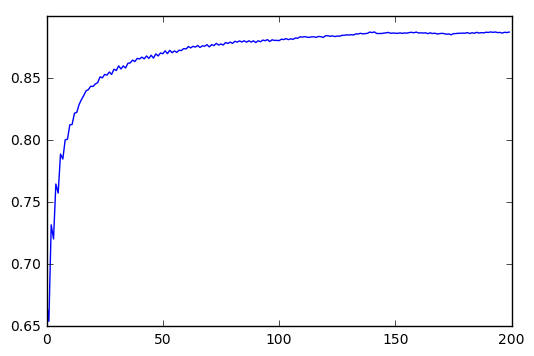

In [338]:
model1.plot(train_frq,y)

<a id='predict'></a>
Model Submission

In [37]:
y_test = np.zeros((len(X_str_test),2))
for _ in range(10):
    for x_bat,bat in batch_iterator(X_str_test, None, model, 10, shuffle=True, sublen=1.0):
        y_test[bat] = y_test[bat] +  predict(x_bat)

In [38]:
test['sentiment'] = y_test[:,1]/10
test['id'] = test.id.str.replace('"','')

In [339]:
test['sentiment'] = model1.predict_proba(test_frq)[:,1]
test['id'] = test.id.str.replace('"','')

In [39]:
test.drop('review',1)\
    .to_csv(r'/home/will/Desktop/data/Movie sentiment/model1.csv',index=False)